In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'../skylens')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy
import time

import psutil
from distributed.utils import format_bytes

#only for python3
import importlib
reload=importlib.reload

In [2]:
from skylens import *
# from fisher import *
from PCA_shear import *

In [3]:
import PCA_shear
reload(PCA_shear)
from PCA_shear import *

In [4]:
import skylens
reload(skylens)
from skylens import *

In [5]:
import survey_utils
reload(survey_utils)
from survey_utils import *

In [6]:
fig_home='./figures/'
fig_format='pdf'

In [7]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='30gb',threads_per_worker=8,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [8]:
client.restart()

Client Scheduler: inproc://192.168.86.85/9979/1 Dashboard: http://192.168.86.85:8787/status,Cluster Workers: 1 Cores: 8 Memory: 30.00 GB


In [9]:
def cosmo_w0_wa(cosmo=None,w0=-1,wa=0):
    attrs=['H0','Om0', 'Ode0','Tcmb0', 'Neff', 'm_nu', 'Ob0']
    args={}
    args['w0']=w0
    args['wa']=wa
    for a in attrs:
        args[a]=getattr(cosmo,a)
    cosmo_w=astropy.cosmology.w0waCDM(**args)
    return cosmo_w
cosmo_w0_wa(cosmo=cosmo)

w0waCDM(H0=67.7 km / (Mpc s), Om0=0.307, Ode0=0.691, w0=-1, wa=0, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [10]:
def cosmo_h_set(cosmo=None,cosmo_params={}):
    if cosmo_params['wa']!=0:
        cosmo=cosmo_w0_wa(cosmo=cosmo,w0=cosmo_params['w'],wa=cosmo_params['wa'])
    cosmo2=cosmo.clone(H0=cosmo_params['h']*100,
                        Om0=cosmo_params['Om'],
                       Ob0=cosmo_params['Omb'],
#                        Odm0=cosmo_params['Omd'],
#                        Ok0=cosmo_params['Omk'],
#                        w=cosmo_params['w'],
                       m_nu=[0,0,cosmo_params['mnu']]*units.eV
                    )

In [11]:
def get_x_var(x0=None,dx_max=0.01,do_log=False,Nx=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    if do_log:
        x0=np.absolute(x0)
        x_vars=x0**Dx
        if x0==1:
            x_vars=(2.**Dx)/2. # 1**x=1
        if x0==0:
            x_vars=np.logspace(-3,-2,Nx)
        x_vars*=np.sign(cosmo_fid[p])
        x_grad=np.gradient(np.log(x_vars))
    else:
        x_vars=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        if x0==0:
            x_vars=Dx-1
        x_grad=np.gradient(x_vars)
    return x_vars,x_grad

In [12]:
def fish_cosmo_model(p='As',Nx=2,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False,z_bins_kwargs={}):
    x0=cosmo_fid[p]

    models={}
    covs={}
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    print(p,x_vars)
    for i in np.arange(Nx):
        cosmo_t=cosmo_fid.copy()

        cosmo_t[p]=x_vars[i]

        if p=='s8':
            s80=cosmo_fid['s8']
            cosmo_t['As']*=(cosmo_t['s8']/s80)**2
            kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
            kappa_class.Ang_PS.PS.pk=None
            x_vars[i]=kappa_class.Ang_PS.PS.s8
#                 print(x_vars[p][i],s80,cosmo_t['s8'])
        cosmo_h2=cosmo_h_set(cosmo=cosmo,cosmo_params=cosmo_t)
        cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t,cosmo_h=cosmo_h2,stack_corr_indxs=z_bins_kwargs['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['pcl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad

In [13]:
def pz_update(z_bins={},bin_indx=None,z_indx=None,pz_new=None):
    z_bins[bin_indx]['pz'][z_indx]=pz_new
    z_bins=zbin_pz_norm(zs_bins=z_bins,bin_indx=bin_indx,zs=z_bins[bin_indx]['z'],p_zs=z_bins[bin_indx]['pz'],ns=z_bins[bin_indx]['ns'])
    return z_bins

In [14]:
def set_zbin_bias0(zs_bins={},bias=0):
    bias0=np.copy(zs_bins['zp_bias'])
    bias0=bias*(1+zs_bins['zp'])
    return bias0

def set_zbin_bias(zs_bins={},bias=0,bin_id=0):
    bias0=np.copy(zs_bins['zp_bias'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    bias0[np.where(idx==bin_id)]=bias
    return bias0

def set_zbin_sigma(zs_bins={},zsigma_frac=1,bin_id=0):
    zp_sigma=np.copy(zs_bins['zp_sigma'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    zp_sigma[np.where(idx==bin_id)]=zp_sigma[np.where(idx==bin_id)]*zsigma_frac
    return zp_sigma
    
def fish_z_model(p='pz_b_s_1',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    z_bins_kwargs=z_bins_kwargs0.copy()
    zs_bins=z_bins_kwargs['zs_bins']
    zl_bins=z_bins_kwargs['zl_bins']
    zlD_bins=z_bins_kwargs['zlD_bins']
    if 'pz_b' in p:
        x0=0
    elif 'nz' in p:
        pp=p.split('_')
        bin_id=np.int(pp[-2])
        z_id=np.int(pp[-1])
        print(bin_id,z_id)
        if 'nz_s' in p:
            x0=zs_bins[bin_id]['pz'][z_id]
        elif 'nz_l' in p:
            x0=zl_bins[bin_id]['pz'][z_id]
            
        if x0<1.e-5:
            x0=0
    else:
        x0=1
        
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        zs_bins_i=zs_bins.copy()
        zl_bins_i=zl_bins.copy()
        if 'pz_B' in p:
            bias=set_zbin_bias0(zs_bins=zs_bins,bias=x_vars[i])
            zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        elif 'pz_b_s' in p:
            bin_id=np.int(p[-1])
            bias=set_zbin_bias(zs_bins=zs_bins,bias=x_vars[i],bin_id=bin_id)
#             zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(z_bias=bias, nbins=z_bins_kwargs['ns_bins'],ns0=z_bins_kwargs['nsource'],z_sigma=z_bins_kwargs['z_source_sigma'],
                                            **z_bins_kwargs)
        elif 'pz_b_l' in p:
            bin_id=np.int(p[-1])#-zs_bins['n_bins']
            bias=set_zbin_bias(zs_bins=zl_bins,bias=x_vars[i],bin_id=bin_id)

            zl_bins_i=lsst_source_tomo_bins(z_bias=bias,nbins=z_bins_kwargs['n_lens_bins'],ns0=z_bins_kwargs['nlens'],z_sigma=z_bins_kwargs['z_lens_sigma'],
                                            **z_bins_kwargs)
        elif 'nz_s' in p:
            zs_bins_i=pz_update(z_bins=zs_bins_i,bin_indx=bin_id,z_indx=z_id,pz_new=x_vars[i])
        elif 'nz_l' in p:
            zl_bins_i=pz_update(z_bins=zl_bins_i,bin_indx=bin_id,z_indx=z_id,pz_new=x_vars[i])

        elif 'sig' in p:
            bin_id=np.int(p[-1])
            zp_sigma=set_zbin_sigma(zs_bins=zs_bins,zsigma_frac=x_vars[i],bin_id=0)
            zs_bins_kwargs['z_sigma']=zp_sigma
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
                
        zl_bins_comb=combine_zbins(z_bins1=zl_bins_i,z_bins2=zlD_bins)
        zl_bins_comb=combine_zbins(z_bins1=zs_bins_i,z_bins2=zl_bins_comb)
        kappa_class.update_zbins(z_bins=zs_bins_i,tracer='shear')
        kappa_class.update_zbins(z_bins=zl_bins_comb,tracer='galaxy')
        cl0G=kappa_class.cl_tomo(stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['pcl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    kappa_class.update_zbins(z_bins=zs_bins,tracer='shear')
    return models,covs,x_vars,x_grad

In [15]:
def fish_galaxy_model(p='g_b_l_11',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,z_bins_kwargs0={}):
    
    z_bins_kwargs=z_bins_kwargs0.copy()
    zs_bins=z_bins_kwargs['zs_bins']
    z_bins=kappa_class.z_bins['galaxy']
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    p_n='b'+p[-2]
    if 'b' in p:
        bin_indx=np.int(p[-1])
        if 'l' in p:
            bin_indx+=zs_bins['n_bins']
        x0=kappa_class.z_bins['galaxy'][bin_indx][p_n]
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        z_bins_t=z_bins.copy()
        if 'b' in p:
            z_bins_t[bin_indx][p_n]=x_vars[i]
        
        kappa_class.update_zbins(z_bins=z_bins_t,tracer='galaxy')
        cl0G=kappa_class.cl_tomo(stack_corr_indxs=z_bins_kwargs0['corr_indxs'])
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['pcl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
        z_bins_t[bin_indx][p[:-1]]=x0
    kappa_class.update_zbins(z_bins=z_bins,tracer='galaxy')
    return models,covs,x_vars,x_grad    

In [16]:
def fish_baryon_model(p='Q1',Nx=2,dx_max=0.01,kappa_class=None,clS=None,cl0=None,do_cov=False,do_log=False,
                      z_bins_kwargs0={},NmarQ=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    if 'Q' in p:
        Q_indx=np.int(p[-1])
        x0=0
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    cov_F=1.#/np.median(np.diag(clS['cov']))
    print(p,clS['cov'].shape,np.linalg.det(clS['cov']*cov_F))
    
    PCS=PCA_shear(kappa_class=kappa_class,NmarQ=NmarQ,clS=clS)
    
    for i in np.arange(Nx):
        Q0=[0]*NmarQ
        Q0[Q_indx]=x_vars[i]
        
        cl_t=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=Q0)
        models[i]=np.zeros_like(cl0) #this is needed to keep everything in right shape. Baryon stuff is only for shear right now. 
        models[i][:len(cl_t)]+=cl_t #['cl_b']
        models[i][len(cl_t):]+=cl0[len(cl_t):]
        print(models[i].shape,PCS.COV.shape)
        covs[i]=PCS.COV
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad    

# PCS=PCA_shear(kappa_class=kappa_class,NmarQ=3)
# cl_t1=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[-10,-10,-10])
# cl_t0=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[0,0,0])

In [17]:
def fisher_calc(cosmo_params=['As'],z_params=[],galaxy_params=[],baryon_params=[],Nx=2,dx_max=0.01,do_log=False,
                kappa_class=None,do_cov=False,baryon_PCA_nQ=2,clS=None,
               Skylens_kwargs={},z_bins_kwargs={},ell_bin_kwargs={},cl0=None,priors=None):
    t1=time.time()
    if kappa_class is None:
        zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
        l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
        kappa_class=Skylens(l=l0,l_bins=l_bins,zs_bins=zs_bins,**Skylens_kwargs)
        
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=do_cov
    cl0G=kappa_class.cl_tomo()
    
    if clS is None:
        kappa_class.do_cov=True #need covariance to start things.
        cl0G=kappa_class.cl_tomo()
    
        clS=cl0G['stack'].compute()
#     cl_t=client.submit(cl0G['stack'])
    cl0=clS['pcl_b']
    t2=time.time()
    print(cl0G['cov'],t2-t1)
    cl_shear=delayed(kappa_class.stack_dat)(dat={'cov':cl0G['cov'],'pcl_b':cl0G['pseudo_cl_b'],'est':'pcl_b'},corrs=[corr_ll],
                                           corr_indxs=z_bins_kwargs['corr_indxs'])
    cl_shear=cl_shear.compute()
#     cl_t=client.submit(cl0G['stack'])
    t3=time.time()
    print('shear',t3-t1)
    
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    cosmo_h=kappa_class.Ang_PS.PS.cosmo_h.clone()
    cov=clS['cov']
    kappa_class.Ang_PS.reset()

    ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)+len(baryon_params)
    params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
    params_all=np.append(params_all,baryon_params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    x_grads={}
    for p in cosmo_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_cosmo_model(p=p,Nx=Nx,dx_max=dx_max,do_log=do_log,
                                                     kappa_class=kappa_class,do_cov=do_cov,z_bins_kwargs=z_bins_kwargs)
    for p in z_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_z_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,z_bins_kwargs0=z_bins_kwargs)
    
    for p in galaxy_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_galaxy_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,z_bins_kwargs0=z_bins_kwargs)
    
    for p in baryon_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_baryon_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,clS=cl_shear,cl0=cl0,
                                                 do_cov=do_cov,NmarQ=baryon_PCA_nQ)
    
    for p in params_all:
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grads[p]
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grads[p]
#             print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params_all:
        i2=0
        for p2 in params_all:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            
            if do_cov:
#                 print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2])
            i2+=1
        i1+=1
    out={}
    out['cov_p_inv']=np.copy(cov_p_inv)
    out['params_all']=params_all
    if priors is not None:
        out=fish_apply_priors(fish=out,priors=priors)
#         i2=0
#         for p1 in params_all:
#             cov_p_inv[i2,i2]+=1./priors[p1]**2
#             i2+=1
    try:
        out['cov_p']=np.linalg.inv(cov_p_inv)
        out['error']=np.sqrt(np.diag(out['cov_p']))
    except Exception as err:
        print(err)

    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov
    out['cov_inv']=cov_inv
    out['model']=models
    out['x_vars']=x_vars
    out['params']=params_all
    kappa_class.do_cov=do_cov0
    return out

In [18]:
def fish_apply_priors(priors=None,fish=[]):
#     ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)+len(baryon_params)
#     params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
#     params_all=np.append(params_all,baryon_params)
    params_all=fish['params_all']
    ndim=len(params_all)
    
    cov_p_inv=np.copy(fish['cov_p_inv'])
    fish['prior']={}
    priors2={}
    i2=0
    for p1 in params_all:
        priors2[p1]=priors[p1]
        cov_p_inv[i2,i2]+=1./priors[p1]**2
        i2+=1
    fish['prior']['cov_p_inv']=cov_p_inv
    fish['prior']['prior']=priors2
    try:
        fish['prior']['cov_p']=np.linalg.inv(cov_p_inv)
        fish['prior']['error']=np.sqrt(np.diag(fish['prior']['cov_p']))
    except Exception as err:
        print(err)
    return fish

In [19]:
k='corrs3_zmin0_barynQ2_pkfclass_pk_SSVFalse'

In [20]:
def get_cl_ells(lmax_cl=1000,lmin_cl=2,Nl_bins=10):
    l0=np.arange(lmin_cl,lmax_cl)

    lmin_cl_Bins=lmin_cl+10
    lmax_cl_Bins=lmax_cl-10
    l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
    

    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
    return l0,l_bins,l


In [21]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
# corrs=[corr_ll] #
corrs=[corr_ggl,corr_gg,corr_ll]

In [22]:
def combine_zbins(z_bins1={},z_bins2={}):
    if z_bins1['n_bins']>0:
        z_bins3=copy.deepcopy(z_bins1)
    else:
        z_bins3=copy.deepcopy(z_bins2)
    if z_bins1['n_bins']==0 or z_bins2['n_bins']==0:
        return z_bins3 
    j=0
    for i in np.arange(z_bins1['n_bins'],z_bins1['n_bins']+z_bins2['n_bins']):
#         print(i,z_bins2.keys())
        z_bins3[i]=copy.deepcopy(z_bins2[j])
        j+=1
    z_bins3['n_bins']+=z_bins2['n_bins']
    nl=z_bins2['SN']['shear'].shape[0]
    z_bins3['SN']={}
    z_bins3['SN']['galaxy']=np.zeros((nl,z_bins3['n_bins'],z_bins3['n_bins']))
    z_bins3['SN']['shear']=np.zeros((nl,z_bins3['n_bins'],z_bins3['n_bins']))
    j=0
    for i in np.arange(z_bins1['n_bins']):
        z_bins3['SN']['galaxy'][:,j,j]+=z_bins1['SN']['galaxy'][:,i,i]
        z_bins3['SN']['shear'][:,j,j]+=z_bins1['SN']['shear'][:,i,i]
        j+=1
    for i in np.arange(z_bins2['n_bins']):
        z_bins3['SN']['galaxy'][:,j,j]+=z_bins2['SN']['galaxy'][:,i,i]
        z_bins3['SN']['shear'][:,j,j]+=z_bins2['SN']['shear'][:,i,i]
        j+=1
    
    return z_bins3

In [23]:
z_min_iter=[0,0.3]
z_max_iter=[3,2]
corrs_iter=[[corr_ll],[corr_ll,corr_ggl,corr_gg]]
pk_iter=['class_pk','baryon_pk']
SSV_iter=[False,True]
nz_iter=[26,20,50]
nbins_iter=[3,1,5]
l_max_iter=[1000,2000,5000]
bary_nQ_iter=[0,2,1,3,5]

cosmo_params=np.atleast_1d(['As','Om','w','wa'])
pz_iter=[[],'pzb']

In [24]:

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False
do_sample_variance=True
use_window=False

window_lmax=30
nside=32

sigma_gamma=0.26
area=15000
f_sky=area*d2r**2/4/np.pi

n_source=26
n_lens=1

In [25]:
zmin=0.3
zmax=2
# power_spectra_kwargs={'pk_func':'baryon_pk'}
pk_params={'non_linear':1,'kmax':30,'kmin':3.e-4,'nk':2000,'scenario':'dmo','pk_func':'baryon_pk'}# 'pk_func':'camb_pk_too_many_z'}
power_spectra_kwargs={'pk_params':pk_params}
nbins=5
n_lens_bins=5
# n_lensD_bins=1 #5
n_zs=50

In [26]:
n_lensD_bins={}
n_lensD_bins['elg']=5
n_lensD_bins['lrg']=3
n_lensD_bins['BG']=2
n_lensD_bins['qso']=3

In [27]:
def get_z_bins(zmin,zmax,ns_bins,n_lens_bins,n_lensD_bins=None,nsource=n_source,nlens=n_lens,nDlens=5,use_window=use_window,
               nside=nside,z_source_sigma=0.05,z_lens_sigma=0.01,area_overlap=0.24,z_max_lens=1.2,f_sky=f_sky,AI=0,AI_z=0,
               mag_fact=0,**kwargs):
    
    zs_bins=lsst_source_tomo_bins(zmin=zmin,zmax=zmax,n_zs=n_zs,nside=nside,ns0=nsource,nbins=ns_bins,f_sky=f_sky,
                                  z_sigma_power=1,z_sigma=z_source_sigma,ztrue_func=ztrue_given_pz_Gaussian,
                                  use_window=use_window,AI=AI,AI_z=AI_z)
    
    zl_bins=lsst_source_tomo_bins(zmin=zmin,zmax=z_max_lens,n_zs=n_zs,ns0=nlens,nbins=n_lens_bins,nside=nside,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,use_window=use_window,mag_fact=mag_fact,
                        z_sigma=z_lens_sigma)
    zlD_bins={}
    zlD_bins['n_bins']=0
    zlD_bins['n_binsF']=0
    zlD_bins['n_binsF1']=0
    zlD_bins['n_binsF2']=0
    zlD_bins['area_overlap']=area_overlap
    if n_lensD_bins is not None:
        zlD_bins=DESI_z_bins(nside=nside,f_sky=f_sky,use_window=use_window,mag_fact=mag_fact,
                             n_zs=n_zs,zmin=zmin,zmax=zmax,
                             mask_start_pix=np.int32(hp.nside2npix(nside)*f_sky*(1-area_overlap)))
        zlD_bins['n_binsF']=0
        zlD_bins['n_binsF1']=0
        zlD_bins['n_binsF2']=0
        if Fmost:
            zlD_bins2=DESI_z_bins(datasets=['lrg']#,'qso']
                                  ,nside=nside,f_sky=f_sky4,use_window=use_window,mag_fact=mag_fact,
                                  mask_start_pix=0)
            zlD_bins3=DESI_z_bins(datasets=['elg'],nside=nside,f_sky=1000./40000,use_window=use_window,mag_fact=mag_fact,
                                  mask_start_pix=0)
            zlD_bins=combine_zbins(z_bins1=zlD_bins,z_bins2=zlD_bins2)
            zlD_bins=combine_zbins(z_bins1=zlD_bins,z_bins2=zlD_bins3)
            zlD_bins['n_binsF1']=zlD_bins2['n_bins']
            zlD_bins['n_binsF2']=zlD_bins3['n_bins']
            zlD_bins['n_binsF']=zlD_bins3['n_bins']+zlD_bins2['n_bins']
    return zs_bins,zl_bins,zlD_bins

In [41]:
def init_fish(z_min=z_min_iter[0],z_max=z_max_iter[0],corrs=corrs_iter[0],SSV=SSV_iter[0],
              pk_func=pk_iter[0],nz=nz_iter[0],n_source_bins=nbins_iter[0],f_sky=0.3,
              l_max=l_max_iter[0],l_min=2,Nl_bins=10,Win=None,store_win=True,mag_fact=0,
             n_lens_bins=3,n_lensD_bins=None,nlens0=10):
    
    pk_params2=copy.deepcopy(pk_params)
    pk_params2['pk_func']=pk_func
    power_spectra_kwargs2={'pk_params':pk_params2}
    
    Skylens_kwargs={'do_cov':do_cov,'bin_cl':bin_cl, #'l':l0,'l_bins':l_bins,
            'SSV_cov':SSV,'tidal_SSV_cov':SSV,'do_xi':False,'use_window':use_window,'window_lmax':window_lmax,
            'f_sky':f_sky,'corrs':corrs,'store_win':store_win,'Win':Win, #'sigma_gamma':sigma_gamma
            'do_sample_variance':do_sample_variance,'power_spectra_kwargs':power_spectra_kwargs2,'f_sky':f_sky,
            'bin_xi':bin_xi}
    
    z_bins_kwargs={'zmin':z_min,'zmax':z_max,'nsource':nz,'ns_bins':nbins,'nside':nside,'n_lens_bins':n_lens_bins,'n_lensD_bins':n_lensD_bins,
                    'use_window':use_window,'nlens':nlens0,'nDlens':nlens0/2.,'area_overlap':0.2, 'f_sky':f_sky,'z_lens_sigma':0.01,
                   'mag_fact':mag_fact,
                   'z_source_sigma':0.05}
    ell_bin_kwargs={'lmax_cl':l_max,'lmin_cl':l_min,'Nl_bins':Nl_bins}
    
    
    zs_bins,zl_bins,zlD_bins=get_z_bins(**z_bins_kwargs)
    
    z_bins_kwargs['zs_bins']=zs_bins
    z_bins_kwargs['zl_bins']=zl_bins
    z_bins_kwargs['zlD_bins']=zlD_bins
    
    n_lensD_bins2=0
    if n_lensD_bins is not None:
        zl_bins_comb=combine_zbins(z_bins1=zl_bins,z_bins2=zlD_bins)
        n_lensD_bins2=zlD_bins['n_bins']
    else:
        zl_bins_comb=zl_bins
    zl_bins_comb=combine_zbins(z_bins1=zs_bins,z_bins2=zl_bins_comb)

    print('nbins',zs_bins['n_bins'],zl_bins['n_bins'],zlD_bins['n_bins'],zl_bins_comb['n_bins'])
    
    ii_lens=np.arange(n_source_bins,n_source_bins+n_lens_bins+n_lensD_bins2)
    ii_s=np.arange(n_source_bins)
    z_bins_kwargs['gg_indxs']=[(i,j) for i in ii_s for j in ii_lens]+[(i,i) for i in ii_lens]
#     for i in np.arange(zl_bins_comb['n_bins']):
#         zl_bins_comb[i]['b1']=1
        
    Skylens_kwargs['zg_bins']=zl_bins_comb    
    
    l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
    print('running Skylens',l0.max(),zl_bins_comb['n_bins'],Skylens_kwargs.keys())
    kappa_class=Skylens(l=l0,l_bins=l_bins,zs_bins=zs_bins,corr_indxs={},**Skylens_kwargs)
    
#     if not use_window:
#         for kk in kappa_class.corr_indxs.keys():
#             indxs=kappa_class.corr_indxs[kk]

#             for (i,j) in indxs:
#                 if i<(n_source_bins+n_lens_bins) and j<(n_source_bins+n_lens_bins):
#                     continue
#                 if i>(n_source_bins+n_lens_bins) and j>(n_source_bins+n_lens_bins):
#                     continue
                    
#                 kappa_class.f_sky[kk][(i,j)]=z_bins_kwargs['f_sky']*z_bins_kwargs['area_overlap']
#                 kappa_class.f_sky[kk[::-1]][(j,i)]=z_bins_kwargs['f_sky']*z_bins_kwargs['area_overlap']
    
    z_bins_kwargs['corr_indxs']=kappa_class.corr_indxs.copy()
    z_bins_kwargs['corr_indxs'][('galaxy','galaxy')]=z_bins_kwargs['gg_indxs']
    return kappa_class,z_bins_kwargs

In [29]:
def DESI_z_bins(datasets=['elg','lrg','BG','qso']
                ,nbins=n_lensD_bins,**kwargs):
    zbins={}
    i=0
    for d in datasets:
        d_bins=DESI_lens_bins(dataset=d,nbins=nbins[d],**kwargs)
        if i==0:
            zbins=copy.deepcopy(d_bins)
        else:
            zbins=combine_zbins(z_bins1=zbins,z_bins2=d_bins)
        i+=1
        print(i,zbins['n_bins'],d_bins['n_bins'])
    return zbins

In [30]:
#setup parameters
l0,l_bins,l=get_cl_ells()
lb=0.5*(l_bins[1:]+l_bins[:-1])

do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [31]:
# corrs=[corr_ll] #
corrs=[corr_ggl,corr_gg,corr_ll]

In [32]:
WIN=None
store_win=False

In [33]:
proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

249.70 MB


In [34]:
fname='temp/win_D_{ns}{nl}{nlD}.pkl'.format(ns=nbins,nl=n_lens_bins,nlD=n_lensD_bins)
if store_win:
    try:
        with open(fname,'rb') as of:
            WIN=pickle.load(of)
    except:
        print('window not found. Will compute')

In [35]:
import importlib
reload=importlib.reload
reload(survey_utils)
from survey_utils import *

In [36]:
Fmost=False

In [37]:
zlD_bins=lsst_source_tomo_bins(ns0=10,nbins=25,nside=256,f_sky=f_sky,
    ztrue_func=ztrue_given_pz_Gaussian,use_window=use_window,
    z_sigma=0.001,mask_start_pix=0)

ns0:  10.0


In [38]:
kappa_class,z_bins_kwargs=init_fish(n_source_bins=nbins,n_lens_bins=n_lens_bins,n_lensD_bins=n_lensD_bins,corrs=corrs,
                                          Win=WIN,store_win=store_win)
lb=0.5*(l_bins[1:]+l_bins[:-1])
# cl0=cl0G['stack'].compute()

ns0:  26.0
ns0:  9.999999999999998
elg 0.0 2.0 [0.  0.4 0.8 1.2 1.6 2. ]
1 5 5
lrg 0.0 1.9 [0.         0.63333333 1.26666667 1.9       ]
2 8 3
BG 0.0 0.5 [0.   0.25 0.5 ]
3 10 2
qso 0.0 3.8 [0.         0.66666667 1.33333333 2.        ]
4 13 3
nbins 5 5 13 23
running Skylens 999 23 dict_keys(['do_cov', 'bin_cl', 'SSV_cov', 'tidal_SSV_cov', 'do_xi', 'use_window', 'window_lmax', 'f_sky', 'corrs', 'store_win', 'Win', 'do_sample_variance', 'power_spectra_kwargs', 'bin_xi', 'zg_bins'])
indxs:  {} {}
Win gen: step size 999 True
Window done


../skylens/survey_utils.py:146: RuntimeWarning: invalid value encountered in double_scalars
  zm=np.sum(zs_bins[i]['z']*zs_bins[i]['pzdz'])/zs_bins[i]['Norm']
../skylens/survey_utils.py:28: RuntimeWarning: invalid value encountered in double_scalars
  SN/=np.sum(zg1['nz']*nz_F*zg1['W'])
../skylens/survey_utils.py:37: RuntimeWarning: invalid value encountered in double_scalars
  SN/=np.sum(zs1['nz']*nz_F*zs1['W'])
../skylens/cov_utils.py:58: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th


In [39]:
z_bins_kwargs['zlD_bins']['n_bins']

13

In [42]:
kappa_class_lsst,z_bins_lsst_kwargs=init_fish(n_source_bins=nbins,n_lens_bins=n_lens_bins,n_lensD_bins=None,corrs=corrs,
                                          Win=WIN,store_win=store_win)
lb=0.5*(l_bins[1:]+l_bins[:-1])



ns0:  26.0
ns0:  9.999999999999998
nbins 5 5 0 10
running Skylens 999 10 dict_keys(['do_cov', 'bin_cl', 'SSV_cov', 'tidal_SSV_cov', 'do_xi', 'use_window', 'window_lmax', 'f_sky', 'corrs', 'store_win', 'Win', 'do_sample_variance', 'power_spectra_kwargs', 'bin_xi', 'zg_bins'])
indxs:  {} {}
Win gen: step size 999 True
Window done


In [43]:
%time cl0G=kappa_class.cl_tomo(corrs=corrs,stack_corr_indxs=z_bins_kwargs['corr_indxs'])
%time cl0G_lsst=kappa_class_lsst.cl_tomo(corrs=corrs,stack_corr_indxs=z_bins_lsst_kwargs['corr_indxs'])

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
../skylens/tracer_utils.py:195: RuntimeWarning: invalid value encountered in true_divide
  z_bins[i]['Gkernel_int']/=z_bins[i]['Norm']
../skylens/tracer_utils.py:235: RuntimeWarning: invalid value encountered in true_divide
  pz_zl/=np.sum(pz_zl*dzl)


cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


CPU times: user 20min 36s, sys: 21.2 s, total: 20min 57s
Wall time: 29min 56s
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
CPU times: user 35.3 s, sys: 478 ms, total: 35.8 s
Wall time: 35.6 s


In [44]:
kappa_class.z_bins['shear'][4]['z'].shape

(50,)

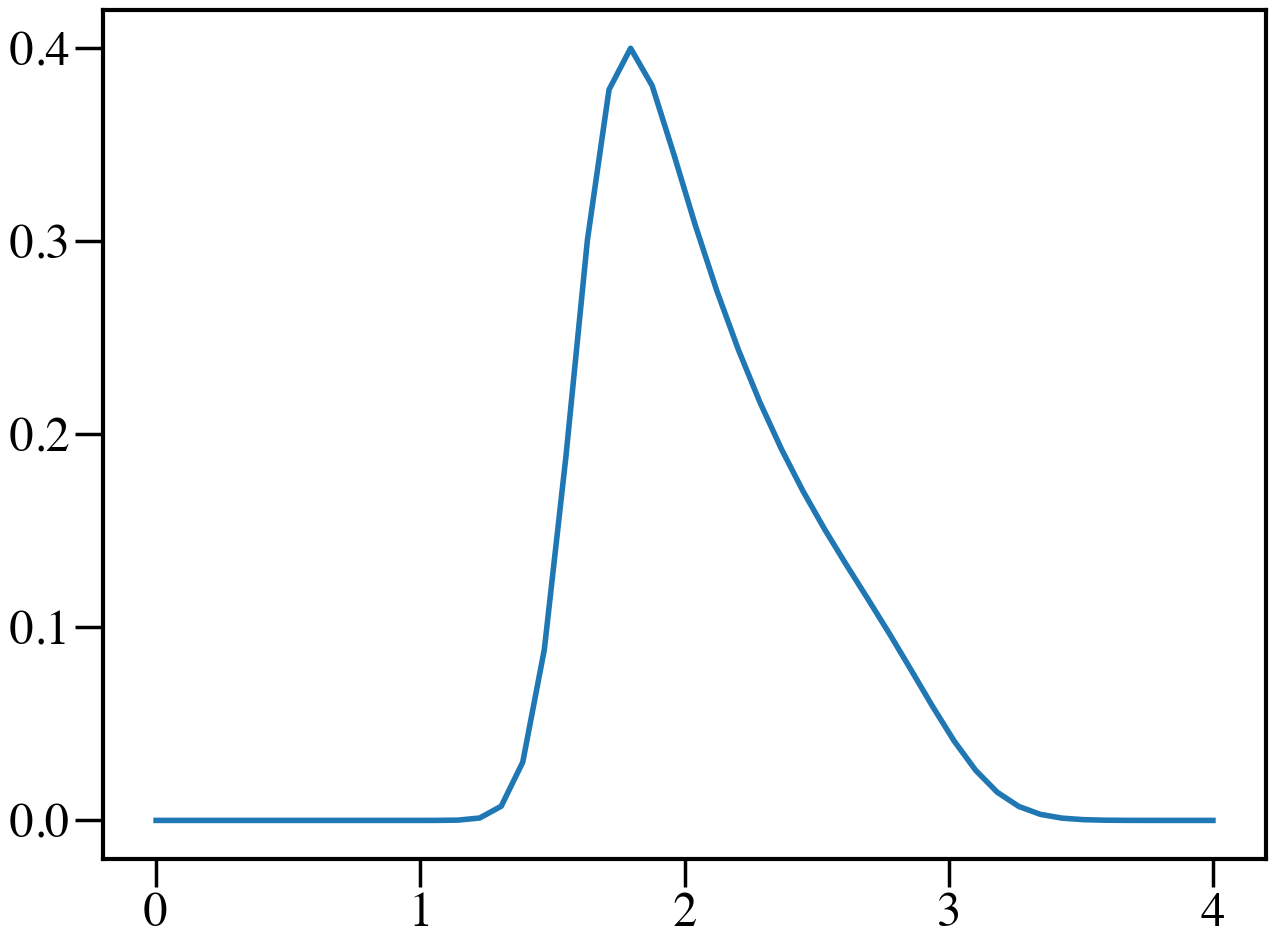

In [45]:
plot(kappa_class.z_bins['shear'][4]['z'],kappa_class.z_bins['shear'][4]['nz'])

In [46]:
proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

21.39 GB


In [47]:
cl_L=None
cl_L_lsst=None


In [48]:
kappa_class_lsst.z_bins['galaxy']['n_bins']

10

In [49]:
if cl_L is None:
    %time cl_L=cl0G['stack'].compute()
#     with open(fname_cl,'wb') as of:
#         pickle.dump(cl_L,of)

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.worker - WARNING - gc.collect() took 47.359s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 24.14 GB -- Worker memory limit: 30.00 GB
distributed.worker - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 23.34 GB -- Worker memory limit: 30.00 GB
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 24.06 GB -- Worker memory limit: 30.00 GB
distributed.worker - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 23.90 GB -- Worker memory limit: 30.00 GB
distributed.utils_perf - WARNING - full garbage

CPU times: user 8h 3min 37s, sys: 2h 13min 28s, total: 10h 17min 5s
Wall time: 2h 46min 20s


In [50]:
if cl_L_lsst is None:
    %time cl_L_lsst=cl0G_lsst['stack'].compute()

distributed.worker - WARNING - gc.collect() took 97.579s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 24.33 GB -- Worker memory limit: 30.00 GB
distributed.worker - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 23.80 GB -- Worker memory limit: 30.00 GB


CPU times: user 26min 32s, sys: 6min 12s, total: 32min 45s
Wall time: 8min 56s


In [51]:
cl_L.keys()

dict_keys(['cov', 'pcl_b'])

In [52]:
cl_L['pcl_b'].shape

(2142,)

In [53]:
4524/lb.shape[0]

502.6666666666667

In [54]:
proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

20.86 GB


In [55]:
if nbins<=2:
    cc=kappa_class.cov_utils
    corr_shear=cc.corr_matrix(cl_L['cov'])
    pcolor(corr_shear,vmin=-1,vmax=1,cmap='seismic')

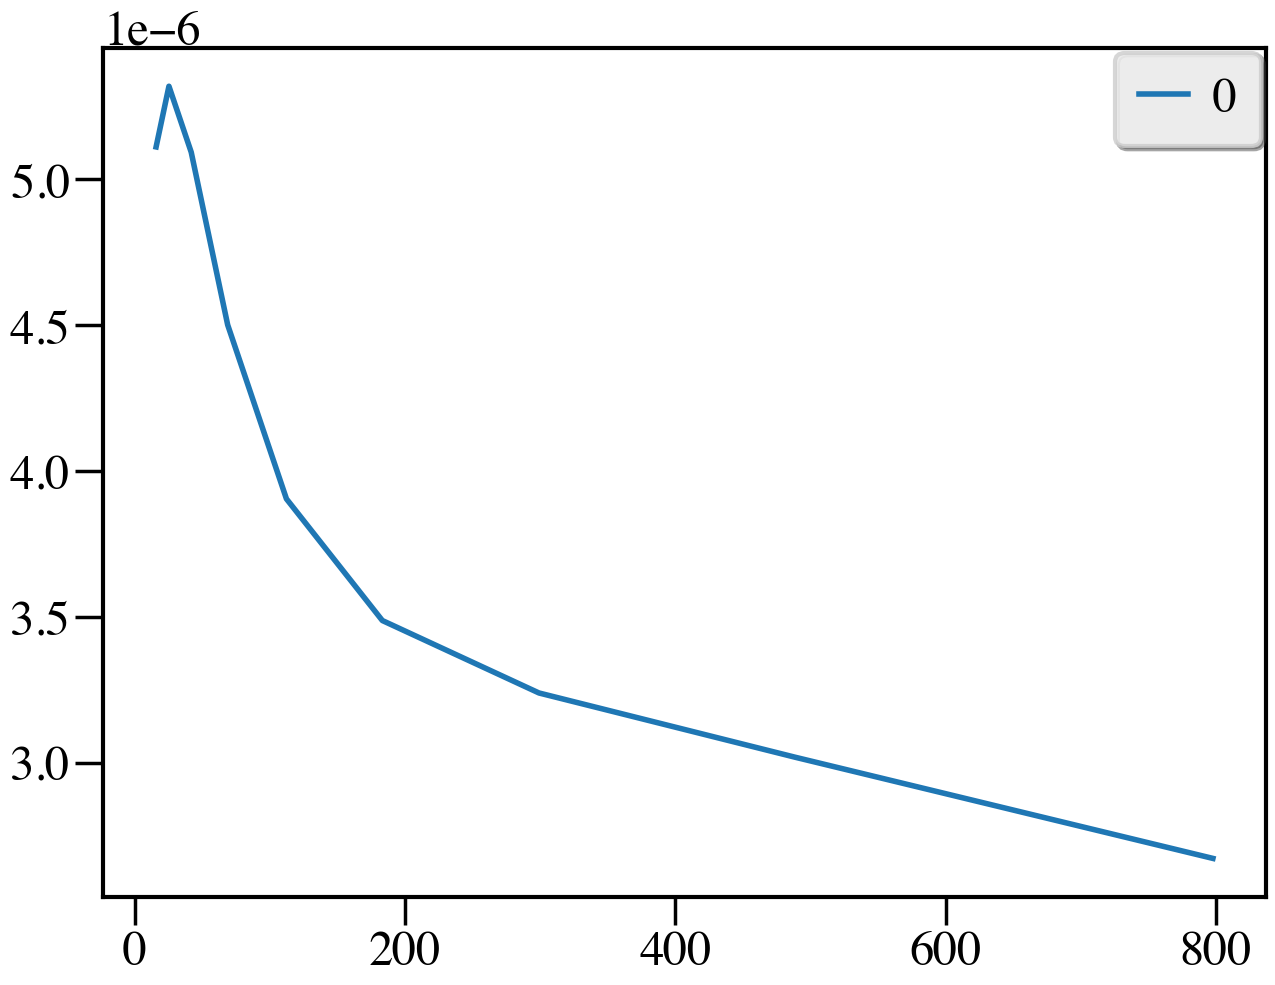

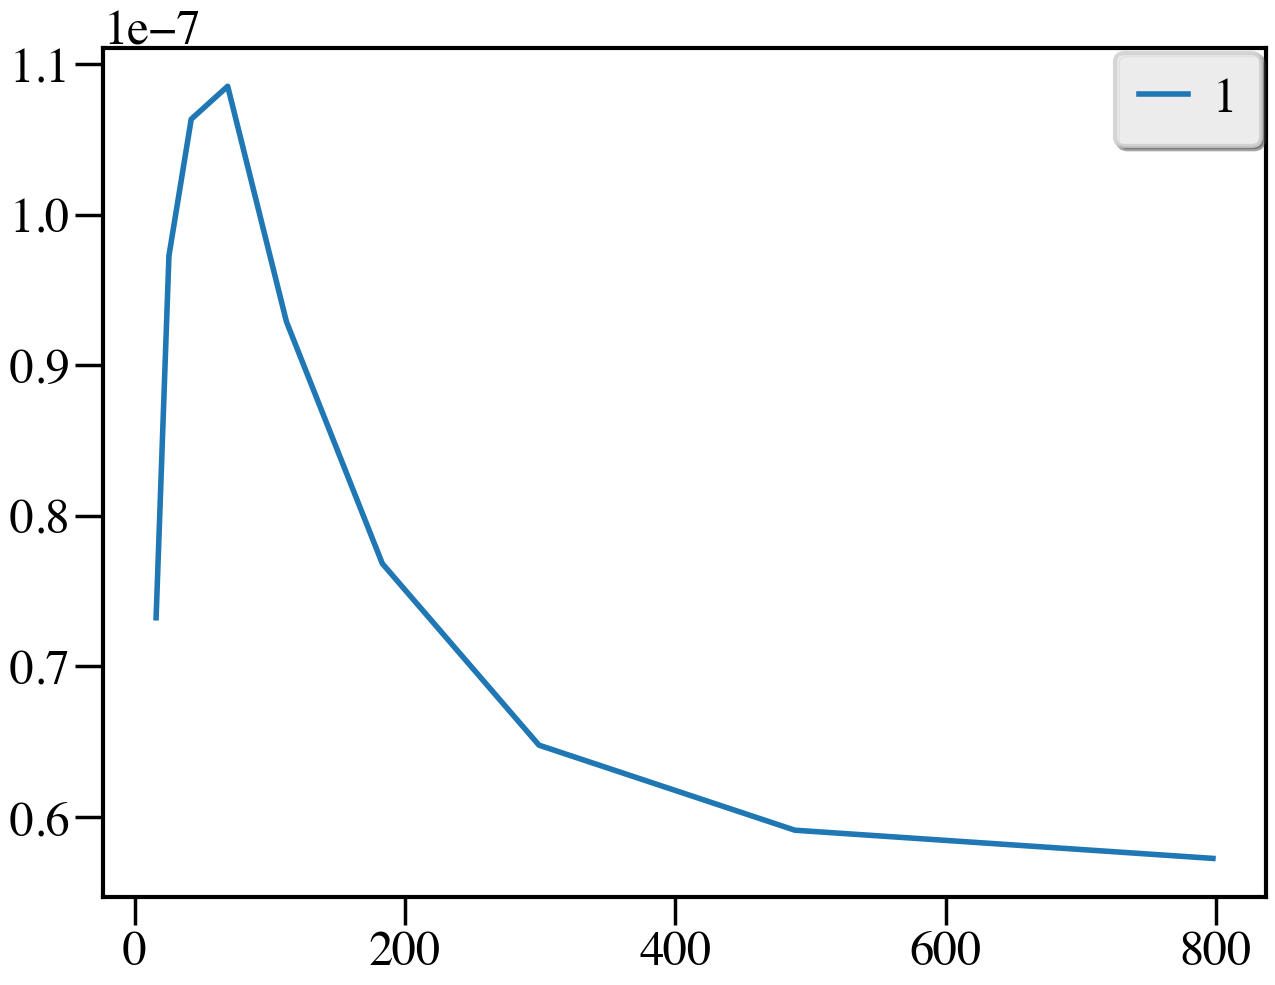

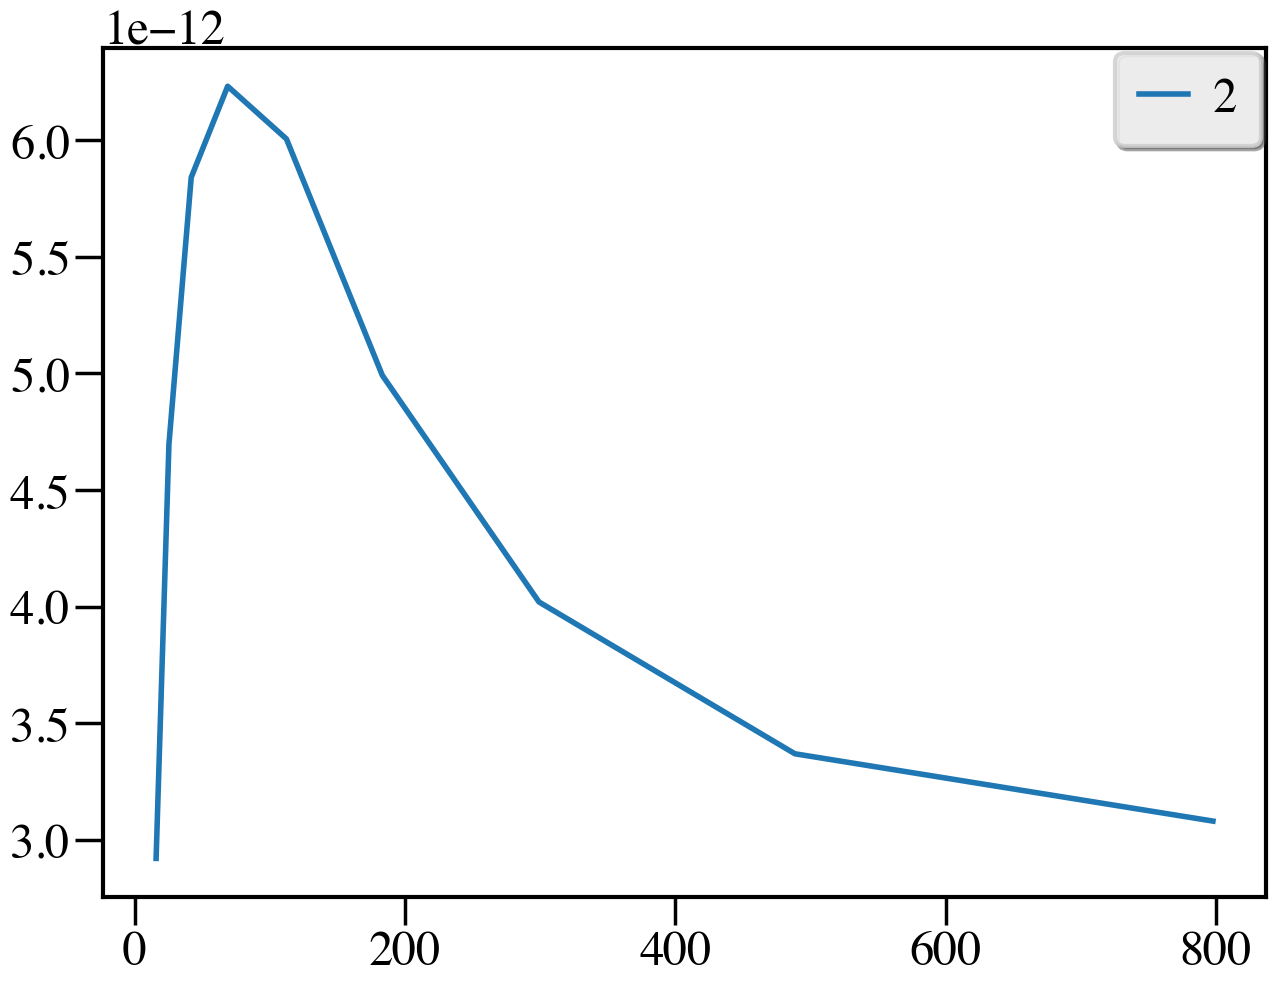

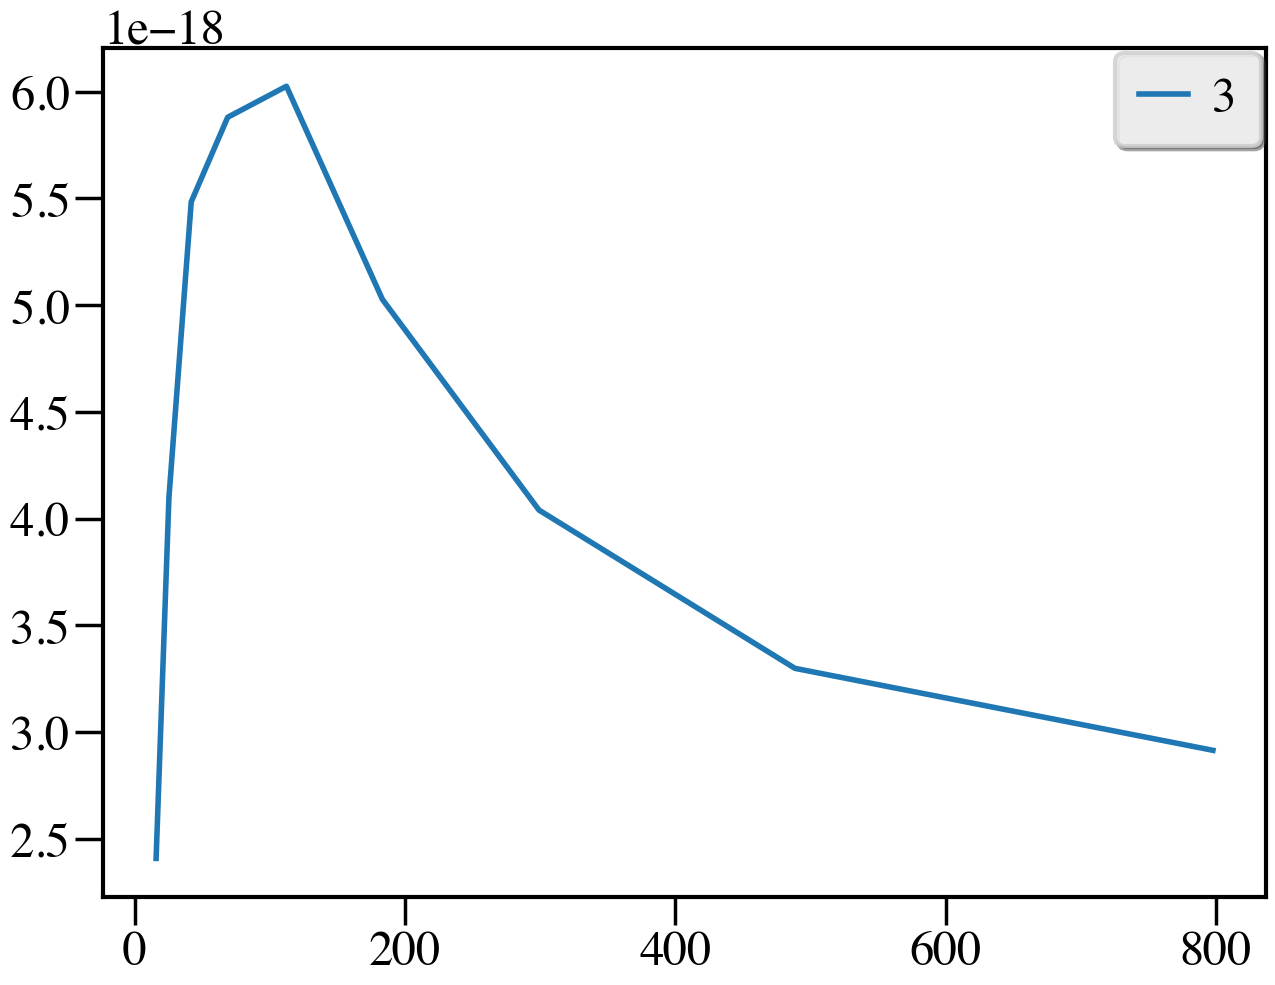

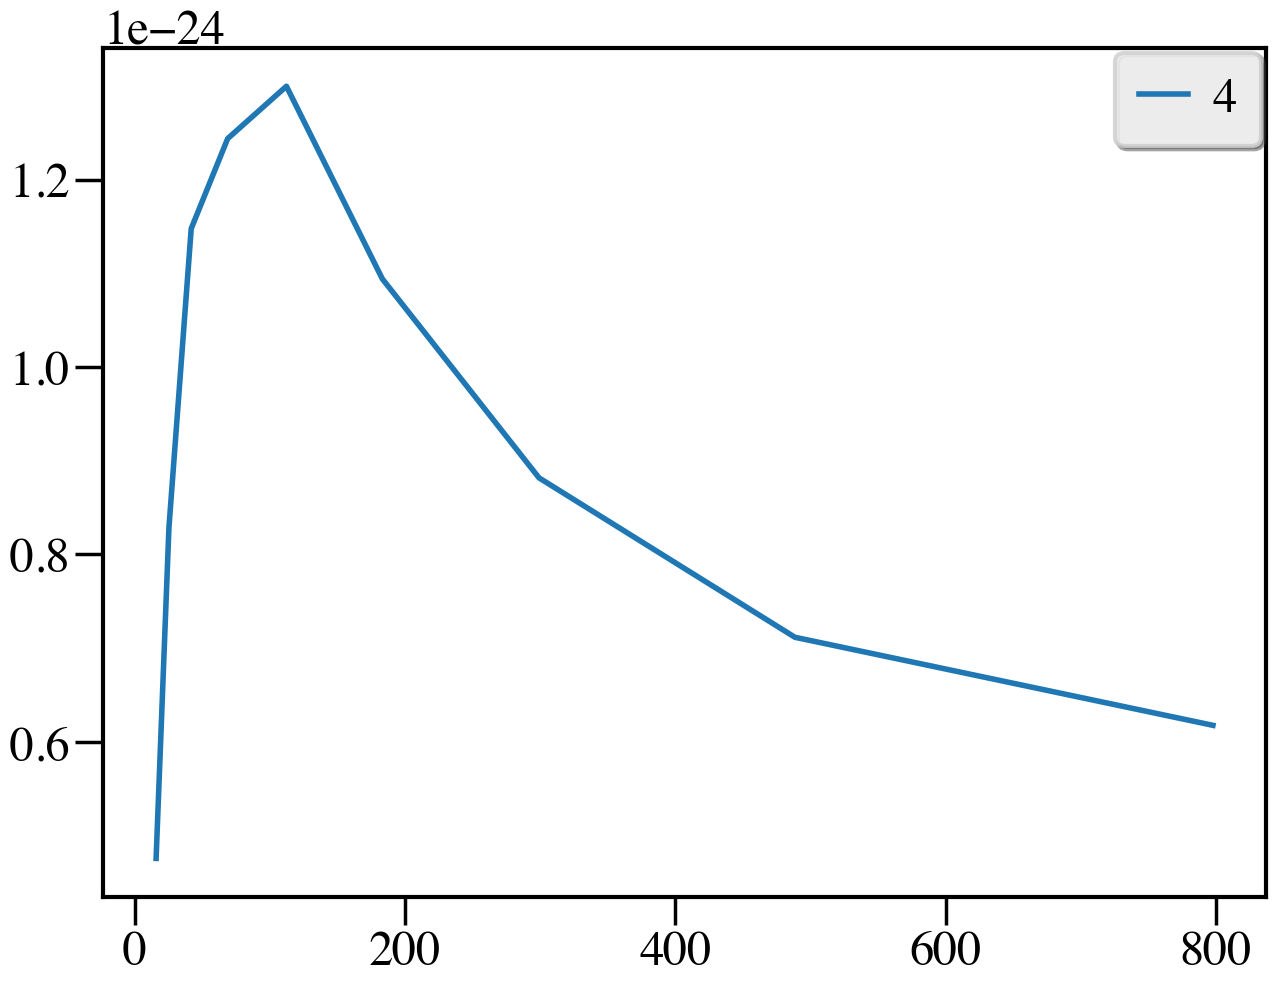

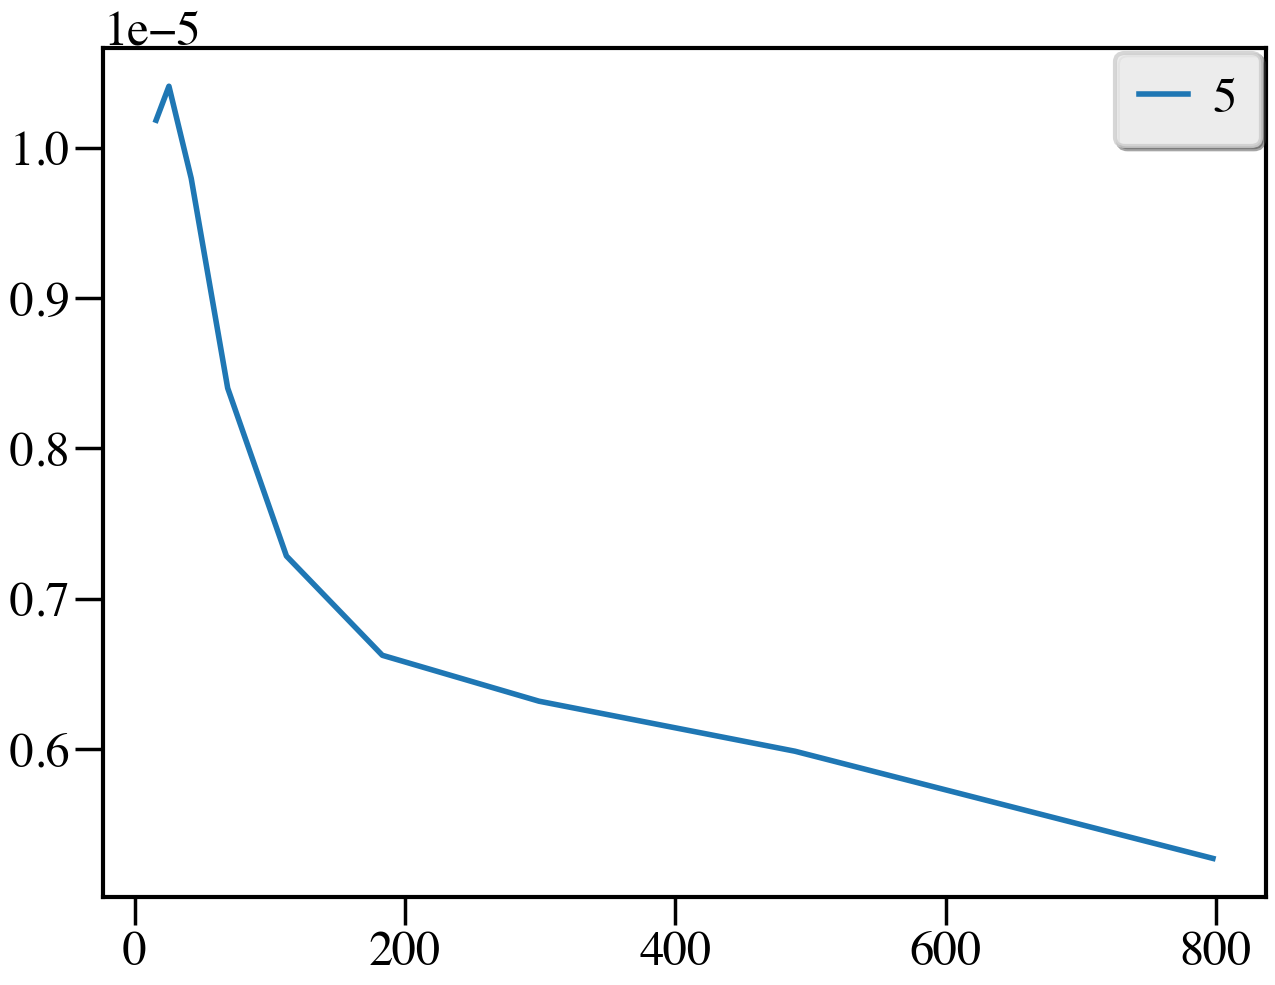

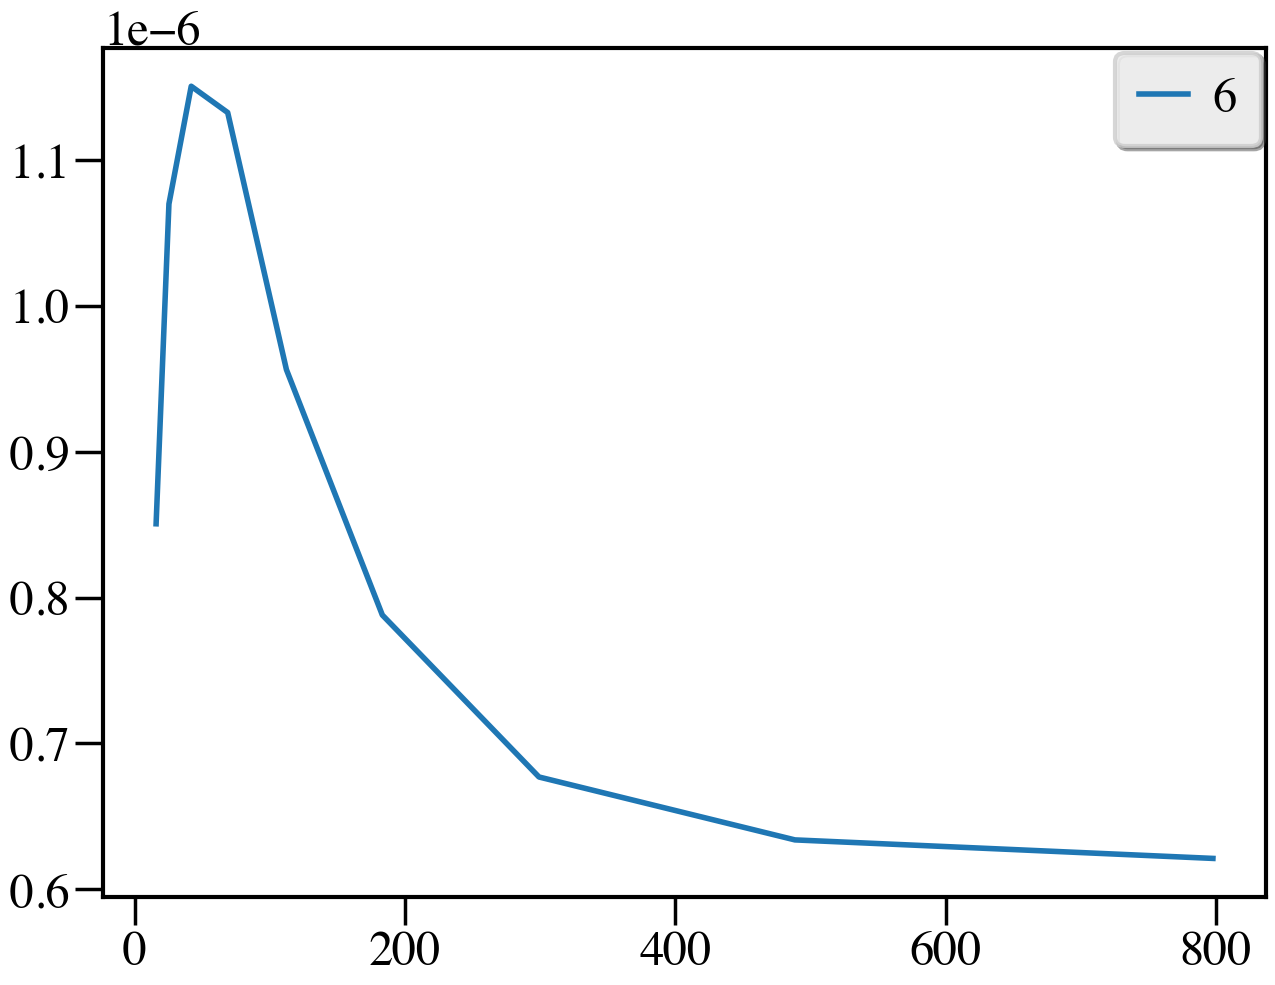

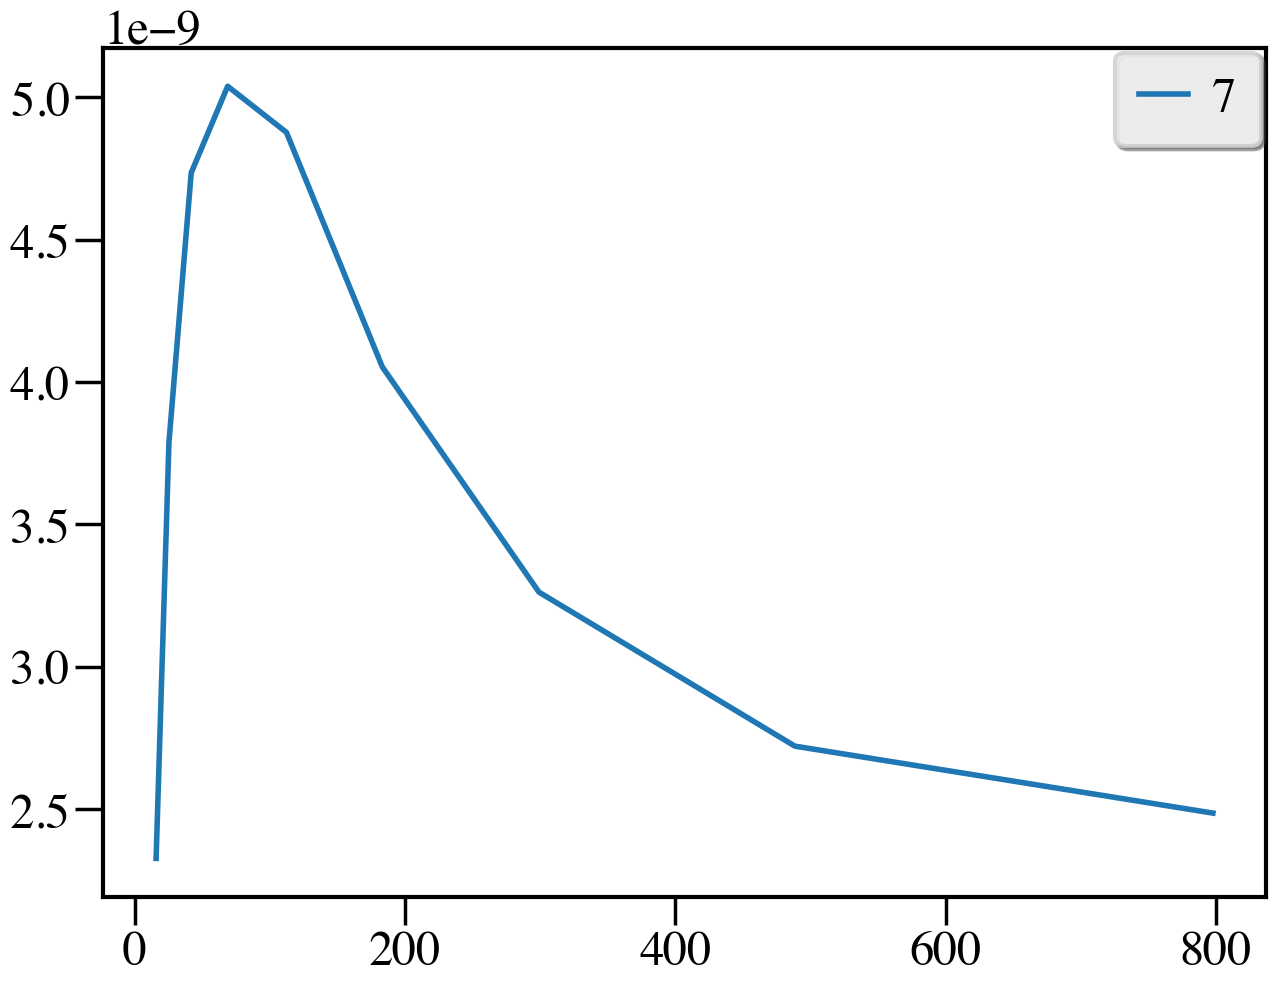

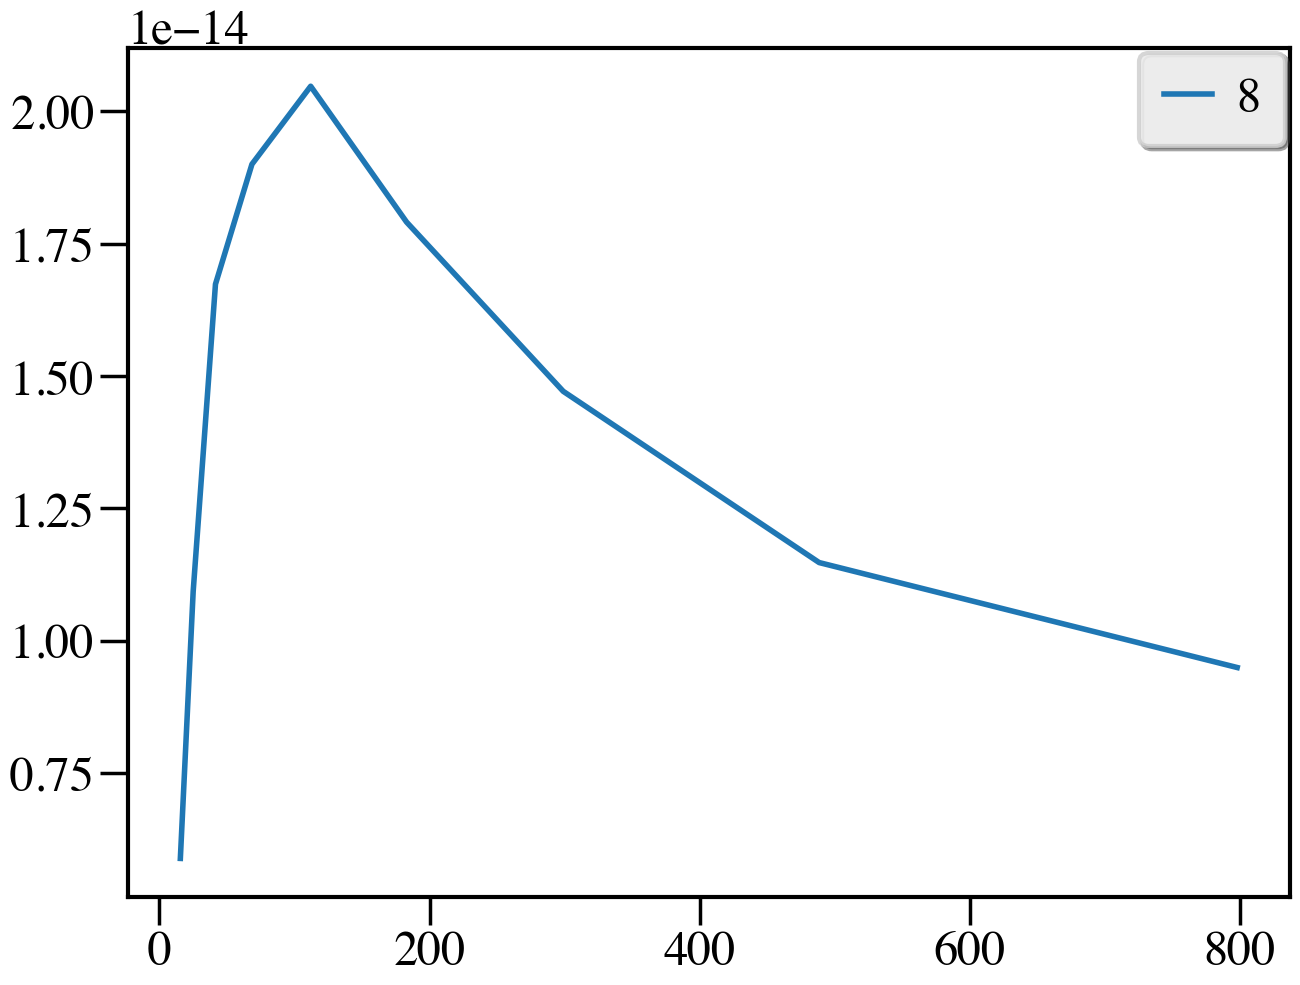

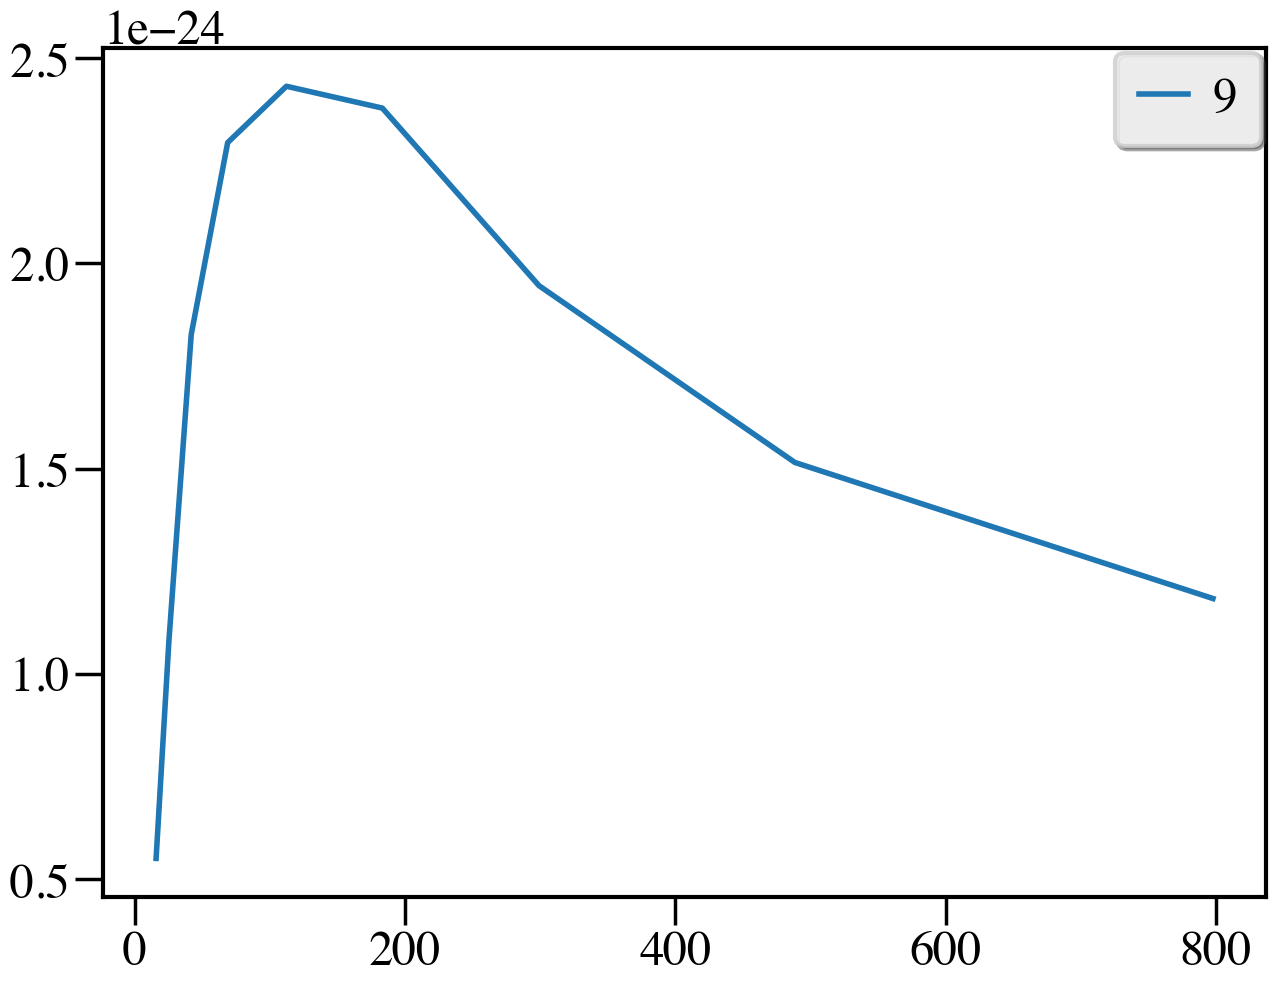

In [56]:
nt=len(lb)
for i in np.arange(10):
    plot(lb,lb*cl_L['pcl_b'][i*nt:(i+1)*nt],label=i)
    legend()
    show()
# yscale('log')

In [57]:
kappa_class.z_bins['galaxy'].keys()

dict_keys(['SN', 0, 1, 2, 3, 4, 'n_bins', 'z_lens_kernel', 'zmax', 'zp', 'pz', 'z_bins', 'zp_sigma', 'zp_bias', 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [58]:
priors={}

In [59]:
priors['Ase9']=np.inf
priors['Om']=np.inf
priors['w']=np.inf
priors['wa']=np.inf

In [60]:
def sigma_photoz(z_bin={}):
    zm=(z_bin['z']*z_bin['pzdz']).sum()
    z=z_bin['z']
    ddz=np.absolute(z-zm)
    p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
    x=np.isnan(p)
    p[x]=z_bin['nz'].max()*0.01
    return p

In [61]:
priors['pz_B_s']=0.001 #bias =B*(1+z) 
priors['pz_B_l']=0.0001 #bias =B*(1+z) 
for i in np.arange(10): #photo-z bias
    priors['pz_b_s_'+str(i)]=0.001

for i in np.arange(10): #photo-z bias
    priors['pz_b_l_'+str(i)]=0.0001

pp_s={}
for i in np.arange(z_bins_kwargs['zs_bins']['n_bins']): #photo-z bias
    pp_s[i]=sigma_photoz(z_bins_kwargs['zs_bins'][i])
    for j in np.arange(n_zs): #photo-z bias
#         priors['nz_s_'+str(i)+'_'+str(j)]=0.01
        priors['nz_s_'+str(i)+'_'+str(j)]=pp_s[i][j]

pp_l={}
for i in np.arange(z_bins_kwargs['zl_bins']['n_bins']): #photo-z bias
    pp_l[i]=sigma_photoz(z_bins_kwargs['zl_bins'][i])/10.
    for j in np.arange(n_zs): #photo-z bias
#         priors['nz_l_'+str(i)+'_'+str(j)]=0.01
        priors['nz_l_'+str(i)+'_'+str(j)]=pp_l[i][j]

        
for i in np.arange(10):#galaxy bias
    priors['g_b_s_1'+str(i)]=1
for i in np.arange(10): #galaxy bias, b2
    priors['g_b_s_2'+str(i)]=1

for i in np.arange(10):#galaxy bias
    priors['g_b_l_1'+str(i)]=1
for i in np.arange(10): #galaxy bias, b2
    priors['g_b_l_2'+str(i)]=1

    
for i in np.arange(10): #baryon PCA
    priors['Q'+str(i)]=100

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


In [62]:
priors

{'Ase9': inf,
 'Om': inf,
 'w': inf,
 'wa': inf,
 'pz_B_s': 0.001,
 'pz_B_l': 0.0001,
 'pz_b_s_0': 0.001,
 'pz_b_s_1': 0.001,
 'pz_b_s_2': 0.001,
 'pz_b_s_3': 0.001,
 'pz_b_s_4': 0.001,
 'pz_b_s_5': 0.001,
 'pz_b_s_6': 0.001,
 'pz_b_s_7': 0.001,
 'pz_b_s_8': 0.001,
 'pz_b_s_9': 0.001,
 'pz_b_l_0': 0.0001,
 'pz_b_l_1': 0.0001,
 'pz_b_l_2': 0.0001,
 'pz_b_l_3': 0.0001,
 'pz_b_l_4': 0.0001,
 'pz_b_l_5': 0.0001,
 'pz_b_l_6': 0.0001,
 'pz_b_l_7': 0.0001,
 'pz_b_l_8': 0.0001,
 'pz_b_l_9': 0.0001,
 'nz_s_0_0': 0.0449146762193082,
 'nz_s_0_1': 0.10674628173455733,
 'nz_s_0_2': 0.15669878661333445,
 'nz_s_0_3': 0.17951699681218478,
 'nz_s_0_4': 0.18814371872578206,
 'nz_s_0_5': 0.14216956471669817,
 'nz_s_0_6': 0.06149895770398592,
 'nz_s_0_7': 0.014797370756255975,
 'nz_s_0_8': 0.002011132032973789,
 'nz_s_0_9': 0.00014826898133621922,
 'nz_s_0_10': 5.71316291044153e-06,
 'nz_s_0_11': 1.1350120034484182e-07,
 'nz_s_0_12': 1.156640682216943e-09,
 'nz_s_0_13': 6.028253966157156e-12,
 'nz_s_0_14'

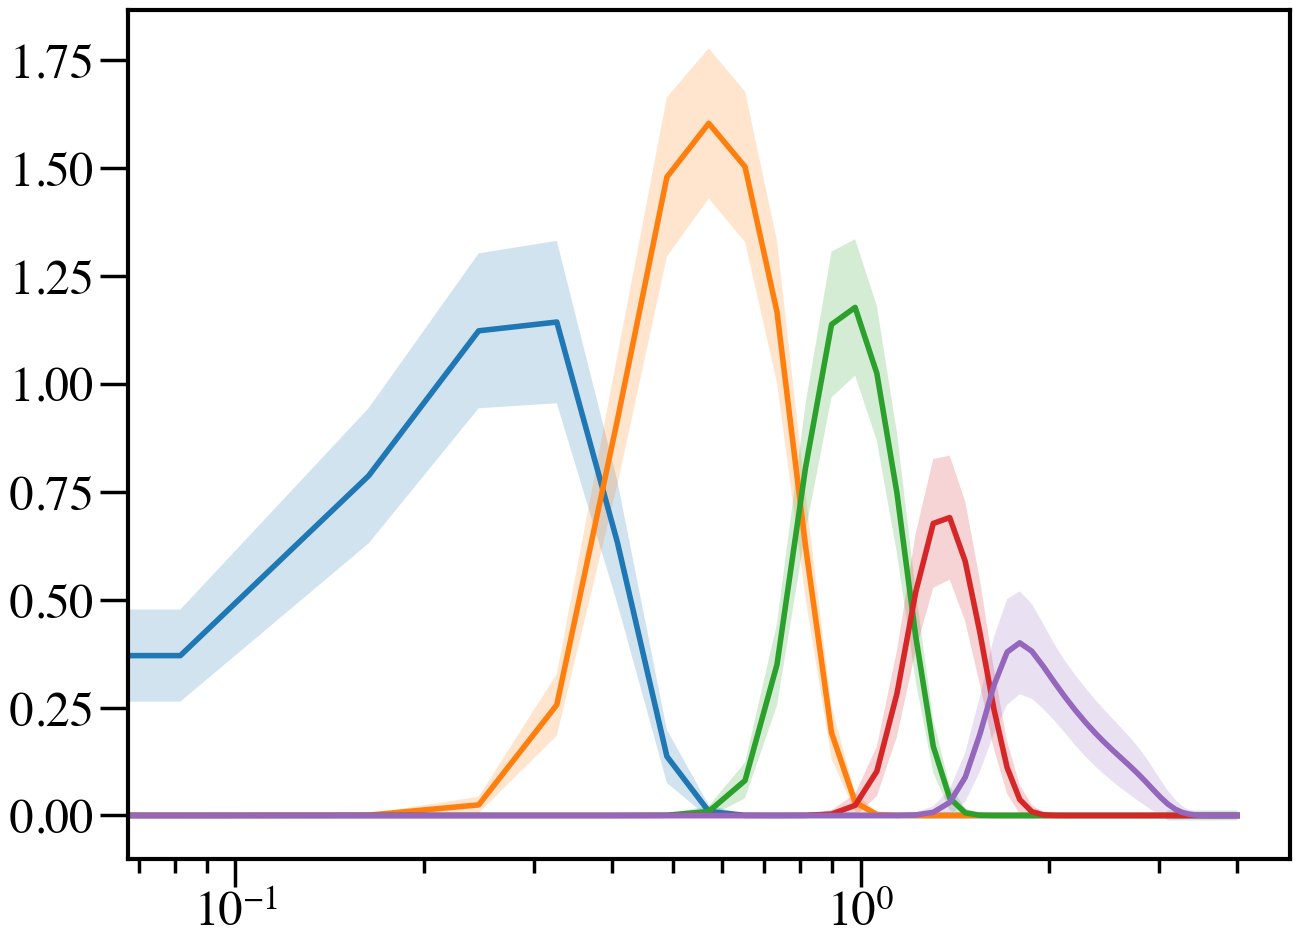

In [63]:
for i in np.arange(5):
# plot(z_bins_kwargs['zs_bins'][i]['z'],pp_s[i],'--')
    plot(z_bins_kwargs['zs_bins'][i]['z'],z_bins_kwargs['zs_bins'][i]['nz'])
    fill_between(z_bins_kwargs['zs_bins'][i]['z'],z_bins_kwargs['zs_bins'][i]['nz']-pp_s[i],z_bins_kwargs['zs_bins'][i]['nz']+pp_s[i],alpha=0.2)
# yscale('log')
xscale('log')

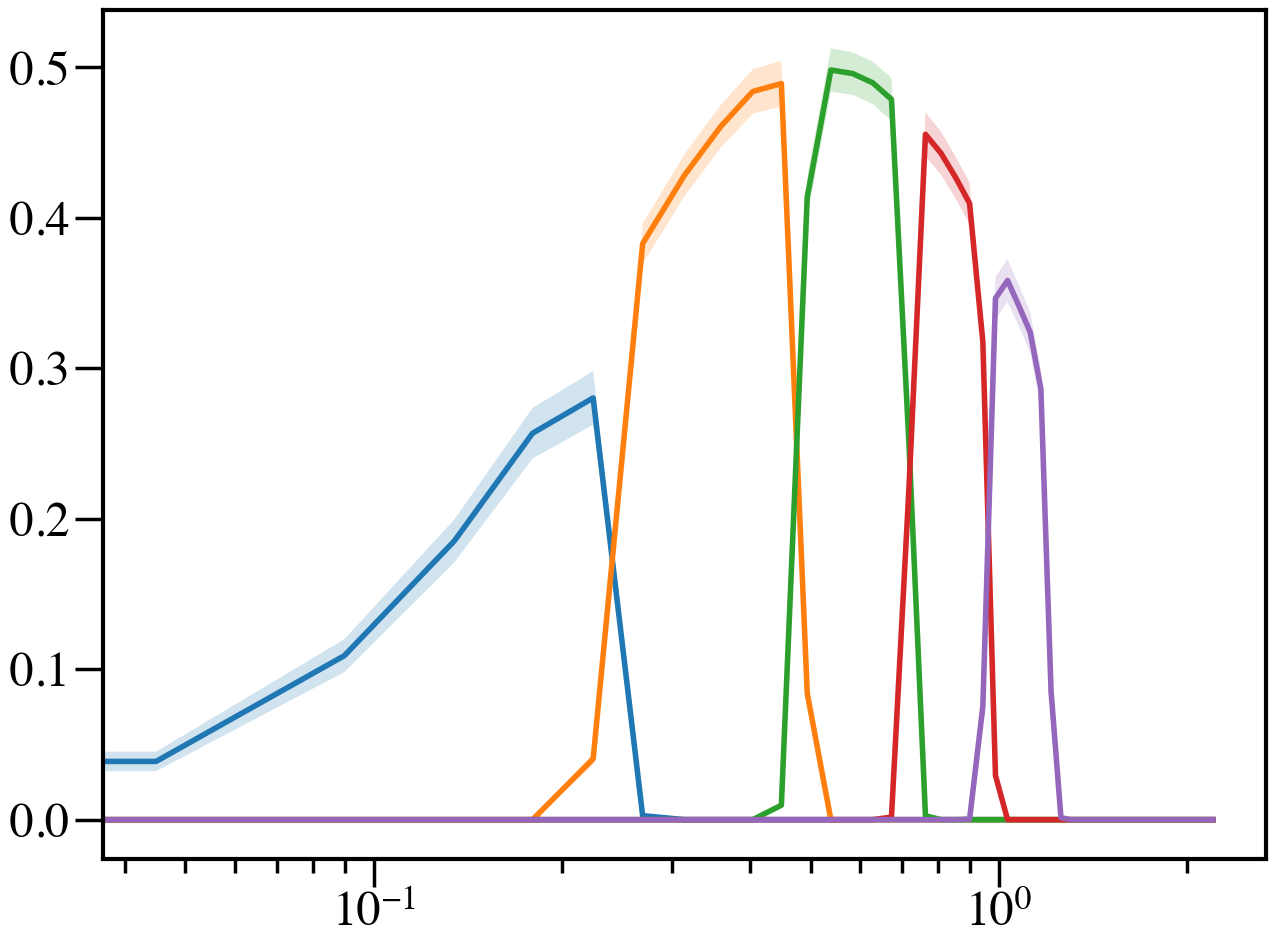

In [64]:
for i in np.arange(5):
# plot(z_bins_kwargs['zs_bins'][i]['z'],pp_s[i],'--')
    plot(z_bins_kwargs['zl_bins'][i]['z'],z_bins_kwargs['zl_bins'][i]['nz'])
    fill_between(z_bins_kwargs['zl_bins'][i]['z'],z_bins_kwargs['zl_bins'][i]['nz']-pp_l[i],z_bins_kwargs['zl_bins'][i]['nz']+pp_l[i],alpha=0.2)
# yscale('log')
xscale('log')

In [65]:
z_bins_kwargs['use_window']=False

In [66]:
if use_window:
    kappa_class.Win.store_win=True

In [67]:
cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()

In [68]:
cosmo_fid.keys()

dict_keys(['h', 'Omb', 'Omd', 's8', 'Om', 'Ase9', 'mnu', 'Omk', 'tau', 'ns', 'w', 'wa', 'Oml'])

In [69]:
priors['pz_b_s_0']

0.001

In [70]:
pz_params=['pz_b_s_{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
pz_params+=['pz_b_l_{j}'.format(j=i) for i in np.arange(n_lens_bins)]
galaxy_params=['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
galaxy_params+=['g_b_l_1{j}'.format(j=i) for i in np.arange(n_lens_bins+z_bins_kwargs['zlD_bins']['n_bins'])]

cosmo_params=np.atleast_1d(['Ase9' ,'Om','w','wa'])

%time f_all=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class,clS=cl_L,z_bins_kwargs=z_bins_kwargs,priors=priors)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
../skylens/tracer_utils.py:195: RuntimeWarning: invalid value encountered in true_divide
  z_bins[i]['Gkernel_int']/=z_bins[i]['Norm']
../skylens/tracer_utils.py:235: RuntimeWarning: invalid value encountered in true_divide
  pz_zl/=np.sum(pz_zl*dzl)


cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
{} 10.450138092041016
shear 10.996531009674072
Ase9 [2.178 2.222]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
Om [0.304425 0.310575]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
w [-0.99 -1.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
wa [-0.01  0.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dic

ValueError: operands could not be broadcast together with shapes (500,) (0,) 

In [71]:
kappa_class.stack_indxs

{}

In [72]:
cl0G.keys()

dict_keys(['stack', 'cl_b', 'cov', 'cl', 'pseudo_cl', 'pseudo_cl_b'])

In [73]:
pz_params=['nz_s_{j}_{k}'.format(j=i,k=k) for i in np.arange(kappa_class.z_bins['shear']['n_bins']) for k in np.arange(n_zs)]
pz_params+=['nz_l_{j}_{k}'.format(j=i,k=k) for i in np.arange(n_lens_bins) for k in np.arange(n_zs)]
galaxy_params=['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])]
galaxy_params+=['g_b_l_1{j}'.format(j=i) for i in np.arange(n_lens_bins+z_bins_kwargs['zlD_bins']['n_bins'])]
# galaxy_params=[]
# print(pz_params)
cosmo_params=np.atleast_1d(['Ase9','Om','w','wa'])

# params_all=np.append(np.append(cosmo_params,pz_params),galaxy_params)
# f_nz_all['params']=params_all
%time f_nz_all=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class,clS=cl_L,z_bins_kwargs=z_bins_kwargs,priors=priors)

cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
{} 9.309358835220337
shear 9.892136812210083
Ase9 [2.178 2.222]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
Om [0.304425 0.310575]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
w [-0.99 -1.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
wa [-0.01  0.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict 

cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
0 29
nz_s_0_29 [-0.01  0.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
0 30
nz_s_0_30 [-0.01  0.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
0 31
nz_s_0_31 [-0.01  0.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
0 32
nz_s_0_32 [-0.01  0.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done

cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
1 12
nz_s_1_12 [0.04696778 0.04791662]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
1 13
nz_s_1_13 [0.00361733 0.0036904 ]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
1 14
nz_s_1_14 [0.00013037 0.000133  ]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('shear', 'shear')])
1 15
nz_s_1_15 [-0.01  0.01]
cl dict done dict_keys([('galaxy', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('s

KeyboardInterrupt: 

In [74]:
f_nz_all=fish_apply_priors(fish=f_nz_all,priors=priors)

NameError: name 'f_nz_all' is not defined

In [ ]:
pz_params=['pz_b_s_{j}'.format(j=i) for i in np.arange(kappa_class_lsst.z_bins['shear']['n_bins'])]
pz_params+=['pz_b_l_{j}'.format(j=i) for i in np.arange(n_lens_bins)]
galaxy_params=['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class_lsst.z_bins['shear']['n_bins'])]
galaxy_params+=['g_b_l_1{j}'.format(j=i) for i in np.arange(n_lens_bins)]

cosmo_params=np.atleast_1d(['Ase9' ,'Om','w','wa'])

%time f_all_lsst=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class_lsst,clS=cl_L_lsst,z_bins_kwargs=z_bins_lsst_kwargs,priors=priors)

In [ ]:
z_bins_lsst_kwargs['zlD_bins']['n_bins']

In [ ]:
pz_params=['nz_s_{j}_{k}'.format(j=i,k=k) for i in np.arange(kappa_class_lsst.z_bins['shear']['n_bins']) for k in np.arange(n_zs)]
pz_params+=['nz_l_{j}_{k}'.format(j=i,k=k) for i in np.arange(n_lens_bins) for k in np.arange(n_zs)]
galaxy_params=['g_b_s_1{j}'.format(j=i) for i in np.arange(kappa_class_lsst.z_bins['shear']['n_bins'])]
galaxy_params+=['g_b_l_1{j}'.format(j=i) for i in np.arange(n_lens_bins)]
# galaxy_params=[]
# print(pz_params)
cosmo_params=np.atleast_1d(['Ase9','Om','w','wa'])

# params_all=np.append(np.append(cosmo_params,pz_params),galaxy_params)
# f_nz_all_lsst['params']=params_all


%time f_nz_all_lsst=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,galaxy_params=galaxy_params,kappa_class=kappa_class_lsst,clS=cl_L_lsst,z_bins_kwargs=z_bins_lsst_kwargs,priors=priors)

In [ ]:
f_nz_all_lsst=fish_apply_priors(fish=f_nz_all_lsst,priors=priors)

In [ ]:
f_all['error'],f_all['prior']['error']

In [ ]:
f_nz_all['error'][:4],f_nz_all['prior']['error'][:4]

In [ ]:
f_nz_all_lsst['error'][:4],f_nz_all_lsst['prior']['error'][:4]

In [ ]:
f_nz_all['error'][:4]/f_all['error'][:4]

In [ ]:
f_nz_all['prior']['error'][:4]/f_all['prior']['error'][:4]

In [ ]:
f['error'][0]/f0['error'][0],f['prior']['error'][0]/f0['prior']['error'][0]

In [ ]:
import plot_fisher_tool
reload(plot_fisher_tool)
from plot_fisher_tool import *

In [ ]:
f_nz_all_lsst['params'].shape, n_lens_bins,n_lensD_bins,n_bins

In [ ]:
f_nz_all['params'].shape

In [ ]:
fish1 = fisher_tool(Fishers={0:f_nz_all_lsst['cov_p_inv'],1:f_nz_all['cov_p_inv']},
                    pars={0:f_nz_all_lsst['params'],1:f_nz_all['params']},
                    par_cen=cosmo_fid#{'Om':0.28374511,'Ase9':0.80351633}
                    ,fisher_titles={0:'LSST',1:'LSST+DESI'})
f=fish1.plot_fish(pars=['Ase9','Om','w','wa'])

In [ ]:
fish1 = fisher_tool(Fishers={0:f_nz_all_lsst['prior']['cov_p_inv'],1:f_nz_all['prior']['cov_p_inv']},
                    pars={0:f_nz_all_lsst['params'],1:f_nz_all['params']},
                    par_cen=cosmo_fid#{'Om':0.28374511,'Ase9':0.80351633}
                    ,fisher_titles={0:'LSST',1:'LSST+DESI'})
f=fish1.plot_fish(pars=['Ase9','Om','w','wa'])

In [ ]:
fish1 = fisher_tool(Fishers={0:f_nz_all_lsst['cov_p_inv'],1:f_nz_all['cov_p_inv'],
                            2:f_nz_all_lsst['prior']['cov_p_inv'],3:f_nz_all['prior']['cov_p_inv']},
                    pars={0:f_nz_all_lsst['params'],1:f_nz_all['params'],
                         2:f_nz_all_lsst['params'],3:f_nz_all['params']},
                    par_cen=cosmo_fid#{'Om':0.28374511,'Ase9':0.80351633}
                    ,fisher_titles={0:'LSST',1:'LSST+DESI',
                                   2:'LSST+p(z) prior',3:'LSST+DESI+p(z) prior'},
                   print_par_error=False)
f=fish1.plot_fish(pars=['Ase9','Om','w','wa'])

In [ ]:
f_nz_all_lsst['model_deriv']['nz_s_0_17']